In [1]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models


In [9]:

video_path = r"D:/VSCODE_JUPYTER/handnew.mp4"  
output_frames_folder = r"D:/VSCODE_JUPYTER/output_video"
os.makedirs(output_frames_folder, exist_ok=True)

cap = cv2.VideoCapture(video_path)
frame_count = 0

while True:
    ret, frame = cap.read()
    if not ret:
        break
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
    cv2.imwrite(os.path.join(output_frames_folder, f'frame_{frame_count:04d}.png'), frame)
    frame_count += 1

cap.release()

Preprocessing

In [14]:

def preprocess_images(folder):
    images = []
    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)
        img = cv2.imread(img_path)
        img = cv2.resize(img, (64, 64))  # Resize to 64x64
        img = img.astype('float32') / 255.0  # Normalize
        images.append(img)
    return np.array(images)

images = preprocess_images(output_frames_folder)


Autoencoder

In [15]:

input_shape = (64, 64, 3)

autoencoder = models.Sequential()
autoencoder.add(layers.InputLayer(input_shape=input_shape))
autoencoder.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same'))
autoencoder.add(layers.MaxPooling2D((2, 2), padding='same'))
autoencoder.add(layers.Conv2D(16, (3, 3), activation='relu', padding='same'))
autoencoder.add(layers.MaxPooling2D((2, 2), padding='same'))
autoencoder.add(layers.Conv2D(8, (3, 3), activation='relu', padding='same'))
autoencoder.add(layers.MaxPooling2D((2, 2), padding='same'))
autoencoder.add(layers.Conv2D(8, (3, 3), activation='relu', padding='same'))
autoencoder.add(layers.UpSampling2D((2, 2)))
autoencoder.add(layers.Conv2D(16, (3, 3), activation='relu', padding='same'))
autoencoder.add(layers.UpSampling2D((2, 2)))
autoencoder.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same'))
autoencoder.add(layers.UpSampling2D((2, 2)))
autoencoder.add(layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same'))  # Output layer

autoencoder.compile(optimizer='adam', loss='mean_squared_error')


Training

In [16]:

autoencoder.fit(images, images, epochs=50, batch_size=16, shuffle=True)

predicted_images = autoencoder.predict(images)

thresholded_frames = []
for i in range(len(images)):
    diff = cv2.absdiff((images[i] * 255).astype(np.uint8), (predicted_images[i] * 255).astype(np.uint8))
    gray_diff = cv2.cvtColor(diff, cv2.COLOR_BGR2GRAY)
    _, thresh = cv2.threshold(gray_diff, 30, 255, cv2.THRESH_BINARY)
    thresholded_frames.append(thresh)


Epoch 1/50
121/121 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - loss: 0.0732
Epoch 2/50
121/121 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 0.0109
Epoch 3/50
121/121 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 0.0091
Epoch 4/50
121/121 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 0.0085
Epoch 5/50
121/121 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.0080
Epoch 6/50
121/121 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 0.0077
Epoch 7/50
121/121 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 0.0069
Epoch 8/50
121/121 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 0.0070
Epoch 9/50
121/121 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 0.0065
Epoch 10/50
121/121 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.0063
Epoch 11/50
121/121 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.0061
Epoch 12/50
121/121 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.0058
Epoch 13/50
121/121 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.0059
Epoch 14/50
121/121 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 0.0056
Epoch 15/50
121/121 ━━━━━━━━━━━━━━━━━━━━ 3s

In [17]:

def create_ground_truth_mask(original_image):
    gray_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2GRAY)
    _, binary_mask = cv2.threshold(gray_image, 127, 255, cv2.THRESH_BINARY)
    return binary_mask


ground_truth_masks = [create_ground_truth_mask((images[i] * 255).astype(np.uint8)) for i in range(len(images))]


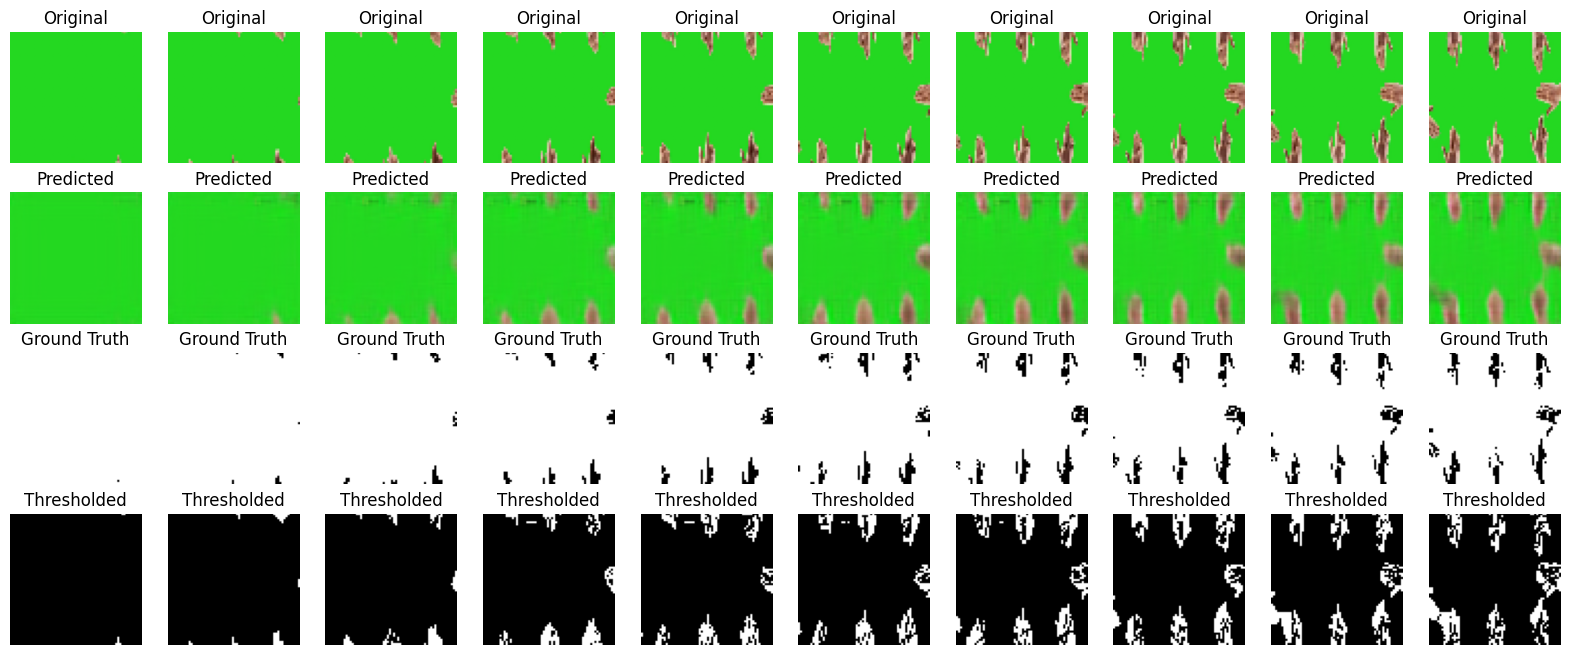

In [18]:

def display_images(original, predicted, ground_truth, thresholded, n=10):
    plt.figure(figsize=(20, 8))
    for i in range(n):
        # Original images
        ax = plt.subplot(4, n, i + 1)
        plt.imshow(original[i])
        plt.axis('off')
        ax.set_title('Original')

        # Predicted images
        ax = plt.subplot(4, n, i + 1 + n)
        plt.imshow(predicted[i])
        plt.axis('off')
        ax.set_title('Predicted')

        # Ground Truth Masks
        ax = plt.subplot(4, n, i + 1 + 2*n)
        plt.imshow(ground_truth[i], cmap='gray')
        plt.axis('off')
        ax.set_title('Ground Truth')

        # Thresholded frames
        ax = plt.subplot(4, n, i + 1 + 3*n)
        plt.imshow(thresholded[i], cmap='gray')
        plt.axis('off')
        ax.set_title('Thresholded')

    plt.show()

display_images(images, predicted_images, ground_truth_masks, thresholded_frames)
